# 📊 Cost Model Simulation Analysis Dashboard

This notebook provides comprehensive analysis tools for examining cost model simulation outputs, including:
- **Campaign Results Analysis** - Compare auto-tuning campaign performance
- **Individual Simulation Deep Dive** - Detailed analysis of specific simulation runs
- **Demographic Analysis** - Age and tenure distribution analysis
- **Performance Metrics** - Headcount growth, compensation trends, retention rates
- **Parameter Sensitivity** - Understanding how configuration changes affect outcomes

## 🚀 Quick Start
1. Set your simulation output path in the configuration section
2. Run the setup cells to load data
3. Use the analysis sections to explore your results

---

## 📋 Configuration & Setup

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import yaml
from pathlib import Path
import warnings
from datetime import datetime, date
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("📦 Libraries loaded successfully!")

📦 Libraries loaded successfully!


In [2]:
# 🔧 CONFIGURATION - Update these paths for your analysis

# Base project directory (adjust if running from different location)
PROJECT_ROOT = Path('..')  # Assumes notebook is in notebooks/ subdirectory

# Campaign results directory (for auto-tuning analysis)
CAMPAIGN_DIR = PROJECT_ROOT / 'campaign_full_results'  # Latest 150-iteration campaign

# Individual simulation output directory (for detailed analysis)
SIMULATION_DIR = PROJECT_ROOT / 'output' / 'Baseline'  # Change to your simulation output

# Alternative: Latest best configuration from campaign
# Find the latest best config by checking campaign_full_results/best_config.yaml
# SIMULATION_DIR = PROJECT_ROOT / 'tuned' / 'output_config_XXX_YYYYMMDD_HHMMSS' / 'Baseline'

# Census file for baseline comparisons
CENSUS_FILE = PROJECT_ROOT / 'data' / 'census_template.parquet'

print(f"📁 Project Root: {PROJECT_ROOT.absolute()}")
print(f"📊 Campaign Directory: {CAMPAIGN_DIR}")
print(f"🎯 Simulation Directory: {SIMULATION_DIR}")
print(f"👥 Census File: {CENSUS_FILE}")

📁 Project Root: /Users/nicholasamaral/Library/Mobile Documents/com~apple~CloudDocs/Development/cost-model/notebooks/..
📊 Campaign Directory: ../campaign_full_results
🎯 Simulation Directory: ../tuned/output_config_101_20250605_163231/Baseline
👥 Census File: ../data/census_template.parquet


## 🎯 Campaign Results Analysis

Analyze auto-tuning campaign performance and compare configurations.

In [3]:
def load_campaign_results(campaign_dir):
    """Load and process campaign results from tuning_results.json"""
    results_file = Path(campaign_dir) / 'tuning_results.json'
    
    if not results_file.exists():
        print(f"❌ Campaign results not found: {results_file}")
        return None
    
    with open(results_file, 'r') as f:
        results = json.load(f)
    
    # Convert to DataFrame for easier analysis
    campaign_df = pd.DataFrame(results)
    
    # Extract summary metrics into separate columns
    summary_df = pd.json_normalize(campaign_df['summary'])
    campaign_df = pd.concat([campaign_df.drop('summary', axis=1), summary_df], axis=1)
    
    print(f"✅ Loaded {len(campaign_df)} campaign results")
    print(f"📊 Available columns: {list(campaign_df.columns)}")
    return campaign_df

def find_best_simulation_output(campaign_dir):
    """Find the simulation output directory for the best configuration"""
    results_file = Path(campaign_dir) / 'tuning_results.json'
    
    if not results_file.exists():
        return None
        
    with open(results_file, 'r') as f:
        results = json.load(f)
    
    # Find best configuration
    best_config = min(results, key=lambda x: x['score'])
    config_path = best_config['config_path']
    
    # Extract config name and find corresponding output directory
    config_name = Path(config_path).stem  # e.g., 'config_000_20250608_174919'
    
    # Look for output directory in tuned folder
    tuned_dir = PROJECT_ROOT / 'tuned'
    for output_dir in tuned_dir.glob(f'output_{config_name}*'):
        baseline_dir = output_dir / 'Baseline'
        if baseline_dir.exists():
            return baseline_dir
    
    return None

# Load campaign results
campaign_results = load_campaign_results(CAMPAIGN_DIR)

# Automatically find best simulation output
best_sim_dir = find_best_simulation_output(CAMPAIGN_DIR)
if best_sim_dir:
    SIMULATION_DIR = best_sim_dir
    print(f"🎯 Auto-detected best simulation: {SIMULATION_DIR}")
else:
    print(f"⚠️  Could not auto-detect best simulation directory")

if campaign_results is not None:
    print(f"\n📈 Campaign Summary:")
    print(f"   Total Configurations: {len(campaign_results)}")
    print(f"   Best Score: {campaign_results['score'].min():.6f}")
    print(f"   Worst Score: {campaign_results['score'].max():.6f}")
    print(f"   Mean Score: {campaign_results['score'].mean():.6f}")
    print(f"   Score Std Dev: {campaign_results['score'].std():.6f}")

✅ Loaded 150 campaign results
📊 Available columns: ['config_path', 'score', 'hc_growth', 'pay_growth', 'total_employees', 'file_path', 'years', 'final_headcount', 'age_hist.40-49', 'age_hist.50-59', 'age_hist.30-39', 'age_hist.65+', 'age_hist.60-65', 'age_hist.<30', 'tenure_hist.5-10', 'tenure_hist.10-15', 'tenure_hist.1-3', 'tenure_hist.3-5', 'tenure_hist.15+', 'tenure_hist.<1']

📈 Campaign Summary:
   Total Configurations: 150
   Best Score: 0.095837
   Worst Score: 0.172973
   Mean Score: 0.126194
   Score Std Dev: 0.014192


## 🧹 Campaign Management

### Clearing the Tuned Folder for New Campaigns

If you want to run another 150-iteration campaign, you can clear the `tuned/` folder to save disk space:

```bash
# ⚠️  WARNING: This will delete ALL previous simulation results!
# Make sure to backup any important configurations first

# Option 1: Remove all tuned results
rm -rf tuned/output_*

# Option 2: Keep only the best configuration from latest campaign
# (Replace XXX with the actual best config number)
find tuned/ -name 'output_config_*' ! -name 'output_config_XXX_*' -exec rm -rf {} +

# Option 3: Archive old results before clearing
tar -czf tuned_archive_$(date +%Y%m%d).tar.gz tuned/
rm -rf tuned/output_*
```

### Running Another Campaign

After clearing space, run another campaign:

```bash
# Standard 150-iteration campaign
python tuning/tune_configs.py --iterations 150 --output-dir campaign_new_results

# Quick validation (50 iterations)
python tuning/tune_configs.py --iterations 50 --output-dir campaign_validation

# Comprehensive search (200+ iterations)
python tuning/tune_configs.py --iterations 200 --output-dir campaign_comprehensive
```

### Disk Space Considerations

- Each simulation generates ~10-50MB of data
- 150 iterations = ~1.5-7.5GB total
- The `tuned/` folder can grow large with multiple campaigns
- Consider archiving or removing old results periodically

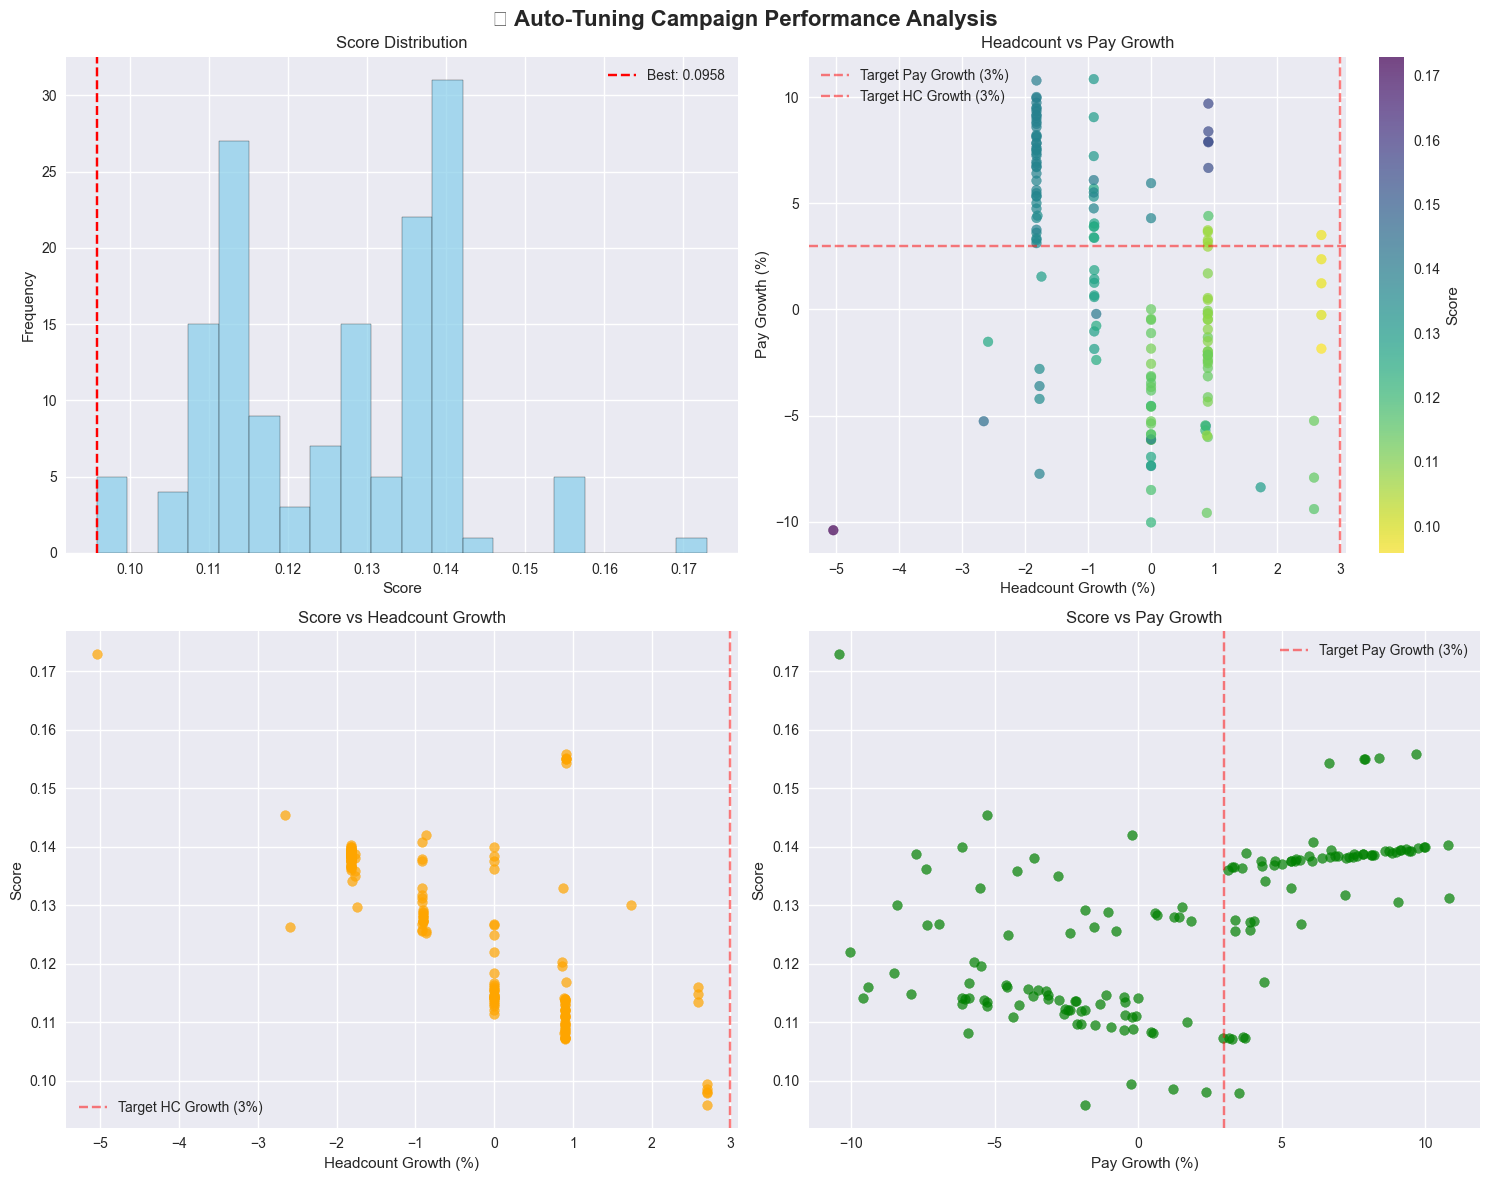


🏆 Top 10 Configurations:


,config_path,score,hc_growth,pay_growth,final_headcount
38,tuned/config_038_20250608_174920.yaml,0.095837,2.7,-1.85,114
16,tuned/config_016_20250608_174920.yaml,0.097886,2.7,3.51,114
79,tuned/config_079_20250608_174920.yaml,0.098154,2.7,2.36,114
145,tuned/config_145_20250608_174921.yaml,0.098519,2.7,1.23,114
27,tuned/config_027_20250608_174920.yaml,0.099467,2.7,-0.26,114
62,tuned/config_062_20250608_174920.yaml,0.107161,0.9,3.27,112
98,tuned/config_098_20250608_174920.yaml,0.107251,0.9,2.96,112
141,tuned/config_141_20250608_174921.yaml,0.107308,0.9,3.16,112
4,tuned/config_004_20250608_174920.yaml,0.107393,0.9,3.73,112
15,tuned/config_015_20250608_174920.yaml,0.107558,0.9,3.65,112


In [4]:
# 📊 Campaign Performance Visualization
if campaign_results is not None:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('🎯 Auto-Tuning Campaign Performance Analysis', fontsize=16, fontweight='bold')
    
    # Score distribution
    axes[0,0].hist(campaign_results['score'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].axvline(campaign_results['score'].min(), color='red', linestyle='--', label=f'Best: {campaign_results["score"].min():.4f}')
    axes[0,0].set_title('Score Distribution')
    axes[0,0].set_xlabel('Score')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].legend()
    
    # Headcount vs Pay Growth scatter
    scatter = axes[0,1].scatter(campaign_results['hc_growth']*100, campaign_results['pay_growth']*100, 
                               c=campaign_results['score'], cmap='viridis_r', alpha=0.7)
    axes[0,1].axhline(3, color='red', linestyle='--', alpha=0.5, label='Target Pay Growth (3%)')
    axes[0,1].axvline(3, color='red', linestyle='--', alpha=0.5, label='Target HC Growth (3%)')
    axes[0,1].set_title('Headcount vs Pay Growth')
    axes[0,1].set_xlabel('Headcount Growth (%)')
    axes[0,1].set_ylabel('Pay Growth (%)')
    axes[0,1].legend()
    plt.colorbar(scatter, ax=axes[0,1], label='Score')
    
    # Score vs Headcount Growth
    axes[1,0].scatter(campaign_results['hc_growth']*100, campaign_results['score'], alpha=0.7, color='orange')
    axes[1,0].axvline(3, color='red', linestyle='--', alpha=0.5, label='Target HC Growth (3%)')
    axes[1,0].set_title('Score vs Headcount Growth')
    axes[1,0].set_xlabel('Headcount Growth (%)')
    axes[1,0].set_ylabel('Score')
    axes[1,0].legend()
    
    # Score vs Pay Growth
    axes[1,1].scatter(campaign_results['pay_growth']*100, campaign_results['score'], alpha=0.7, color='green')
    axes[1,1].axvline(3, color='red', linestyle='--', alpha=0.5, label='Target Pay Growth (3%)')
    axes[1,1].set_title('Score vs Pay Growth')
    axes[1,1].set_xlabel('Pay Growth (%)')
    axes[1,1].set_ylabel('Score')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Top 10 configurations
    print("\n🏆 Top 10 Configurations:")
    top_configs = campaign_results.nsmallest(10, 'score')[['config_path', 'score', 'hc_growth', 'pay_growth', 'final_headcount']]
    top_configs['hc_growth'] = (top_configs['hc_growth'] * 100).round(2)
    top_configs['pay_growth'] = (top_configs['pay_growth'] * 100).round(2)
    top_configs['score'] = top_configs['score'].round(6)
    display(top_configs)

## 👥 Demographic Analysis

Analyze age and tenure distributions from campaign results or individual simulations.

📊 Available columns: ['config_path', 'score', 'hc_growth', 'pay_growth', 'total_employees', 'file_path', 'years', 'final_headcount', 'age_hist.40-49', 'age_hist.50-59', 'age_hist.30-39', 'age_hist.65+', 'age_hist.60-65', 'age_hist.<30', 'tenure_hist.5-10', 'tenure_hist.10-15', 'tenure_hist.1-3', 'tenure_hist.3-5', 'tenure_hist.15+', 'tenure_hist.<1']


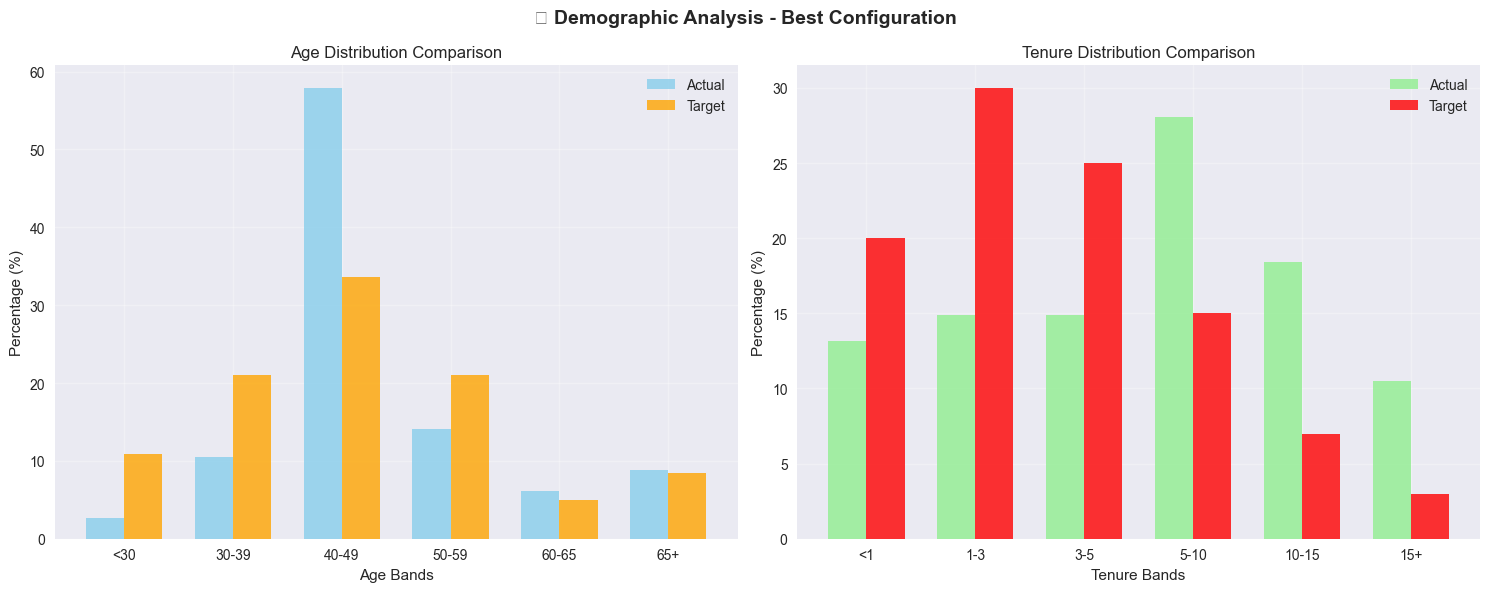


📊 Configuration: tuned/config_038_20250608_174920.yaml
🎯 Score: 0.095837
📈 HC Growth: 2.70% (Target: 3.0%)
💰 Pay Growth: -1.85% (Target: 3.0%)

🎂 Age Distribution Errors (percentage points):
   <30: 8.3pp ❌
   30-39: 10.5pp ❌
   40-49: 24.3pp ❌
   50-59: 7.0pp ❌
   60-65: 1.1pp ✅
   65+: 0.4pp ✅

⏱️ Tenure Distribution Errors (percentage points):
   <1: 6.8pp ❌
   1-3: 15.1pp ❌
   3-5: 10.1pp ❌
   5-10: 13.1pp ❌
   10-15: 11.4pp ❌
   15+: 7.5pp ❌


In [5]:
def analyze_demographics(campaign_results=None, config_name=None):
    """Analyze age and tenure distributions"""
    if campaign_results is None:
        print("❌ No campaign results loaded")
        return
    
    # Debug: Check available columns
    print(f"📊 Available columns: {list(campaign_results.columns)}")
    
    # Get best configuration or specific config
    if config_name:
        config_data = campaign_results[campaign_results['config_path'].str.contains(config_name)]
        if config_data.empty:
            print(f"❌ Configuration '{config_name}' not found")
            return
        config_data = config_data.iloc[0]
        title_suffix = f" - {config_name}"
    else:
        config_data = campaign_results.loc[campaign_results['score'].idxmin()]
        title_suffix = " - Best Configuration"
    
    # Extract age and tenure distributions from flattened columns
    # pd.json_normalize creates columns like 'age_hist.30-39', 'tenure_hist.<1', etc.
    age_hist = {}
    tenure_hist = {}
    
    # Reconstruct age_hist dictionary from flattened columns
    for col in config_data.index:
        if col.startswith('age_hist.'):
            band = col.replace('age_hist.', '')
            age_hist[band] = config_data[col]
        elif col.startswith('tenure_hist.'):
            band = col.replace('tenure_hist.', '')
            tenure_hist[band] = config_data[col]
    
    # Target distributions (from census and baseline)
    target_age = {
        '<30': 0.109, '30-39': 0.210, '40-49': 0.336, 
        '50-59': 0.210, '60-65': 0.050, '65+': 0.084
    }
    target_tenure = {
        '<1': 0.20, '1-3': 0.30, '3-5': 0.25, 
        '5-10': 0.15, '10-15': 0.07, '15+': 0.03
    }
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f'👥 Demographic Analysis{title_suffix}', fontsize=14, fontweight='bold')
    
    # Age distribution comparison
    age_bands = list(target_age.keys())
    actual_age = [age_hist.get(band, 0) for band in age_bands]
    target_age_vals = [target_age[band] for band in age_bands]
    
    x = np.arange(len(age_bands))
    width = 0.35
    
    axes[0].bar(x - width/2, [v*100 for v in actual_age], width, label='Actual', alpha=0.8, color='skyblue')
    axes[0].bar(x + width/2, [v*100 for v in target_age_vals], width, label='Target', alpha=0.8, color='orange')
    axes[0].set_title('Age Distribution Comparison')
    axes[0].set_xlabel('Age Bands')
    axes[0].set_ylabel('Percentage (%)')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(age_bands)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Tenure distribution comparison
    tenure_bands = list(target_tenure.keys())
    actual_tenure = [tenure_hist.get(band, 0) for band in tenure_bands]
    target_tenure_vals = [target_tenure[band] for band in tenure_bands]
    
    x = np.arange(len(tenure_bands))
    
    axes[1].bar(x - width/2, [v*100 for v in actual_tenure], width, label='Actual', alpha=0.8, color='lightgreen')
    axes[1].bar(x + width/2, [v*100 for v in target_tenure_vals], width, label='Target', alpha=0.8, color='red')
    axes[1].set_title('Tenure Distribution Comparison')
    axes[1].set_xlabel('Tenure Bands')
    axes[1].set_ylabel('Percentage (%)')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(tenure_bands)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate errors
    age_errors = {band: abs(actual_age[i] - target_age_vals[i]) * 100 
                  for i, band in enumerate(age_bands)}
    tenure_errors = {band: abs(actual_tenure[i] - target_tenure_vals[i]) * 100 
                     for i, band in enumerate(tenure_bands)}
    
    print(f"\n📊 Configuration: {config_data['config_path']}")
    print(f"🎯 Score: {config_data['score']:.6f}")
    print(f"📈 HC Growth: {config_data['hc_growth']*100:.2f}% (Target: 3.0%)")
    print(f"💰 Pay Growth: {config_data['pay_growth']*100:.2f}% (Target: 3.0%)")
    
    print("\n🎂 Age Distribution Errors (percentage points):")
    for band, error in age_errors.items():
        status = "✅" if error < 2 else "⚠️" if error < 5 else "❌"
        print(f"   {band}: {error:.1f}pp {status}")
    
    print("\n⏱️ Tenure Distribution Errors (percentage points):")
    for band, error in tenure_errors.items():
        status = "✅" if error < 2 else "⚠️" if error < 5 else "❌"
        print(f"   {band}: {error:.1f}pp {status}")

# Analyze demographics for best configuration
if campaign_results is not None:
    analyze_demographics(campaign_results)

## 📈 Individual Simulation Deep Dive

Load and analyze detailed results from a specific simulation run.

In [6]:
def load_simulation_data(simulation_dir):
    """Load simulation output files for detailed analysis"""
    sim_path = Path(simulation_dir)
    
    if not sim_path.exists():
        print(f"❌ Simulation directory not found: {sim_path}")
        return None
    
    data = {}
    
    # Load metrics summary
    metrics_file = sim_path / 'Baseline_metrics.csv'
    if metrics_file.exists():
        data['metrics'] = pd.read_csv(metrics_file)
        print(f"✅ Loaded metrics: {len(data['metrics'])} rows")
    
    # Load yearly snapshots
    snapshots = {}
    for year_dir in sim_path.glob('year=*'):
        year = year_dir.name.split('=')[1]
        snapshot_file = year_dir / 'snapshot.parquet'
        if snapshot_file.exists():
            snapshots[year] = pd.read_parquet(snapshot_file)
            print(f"✅ Loaded {year} snapshot: {len(snapshots[year])} employees")
    
    data['snapshots'] = snapshots
    
    # Load event logs if available
    events = {}
    for year_dir in sim_path.glob('year=*'):
        year = year_dir.name.split('=')[1]
        for event_file in year_dir.glob('*_events.parquet'):
            event_type = event_file.stem.replace('_events', '')
            if year not in events:
                events[year] = {}
            events[year][event_type] = pd.read_parquet(event_file)
            print(f"✅ Loaded {year} {event_type} events: {len(events[year][event_type])} records")
    
    data['events'] = events
    
    return data

# Load simulation data
simulation_data = load_simulation_data(SIMULATION_DIR)

if simulation_data and 'metrics' in simulation_data:
    print(f"\n📊 Simulation Summary:")
    metrics = simulation_data['metrics']
    if len(metrics) > 0:
        latest = metrics.iloc[-1]
        print(f"   Final Year: {latest.get('year', 'N/A')}")
        print(f"   Final Headcount: {latest.get('total_employees', 'N/A')}")
        print(f"   Total Compensation: ${latest.get('total_compensation', 0):,.0f}")
        if 'hc_growth_rate' in latest:
            print(f"   HC Growth Rate: {latest['hc_growth_rate']*100:.2f}%")
        if 'comp_growth_rate' in latest:
            print(f"   Comp Growth Rate: {latest['comp_growth_rate']*100:.2f}%")

✅ Loaded metrics: 3 rows
✅ Loaded 2027 snapshot: 122 employees
✅ Loaded 2026 snapshot: 122 employees
✅ Loaded 2025 snapshot: 120 employees

📊 Simulation Summary:
   Final Year: 2027.0
   Final Headcount: N/A
   Total Compensation: $20,742,336


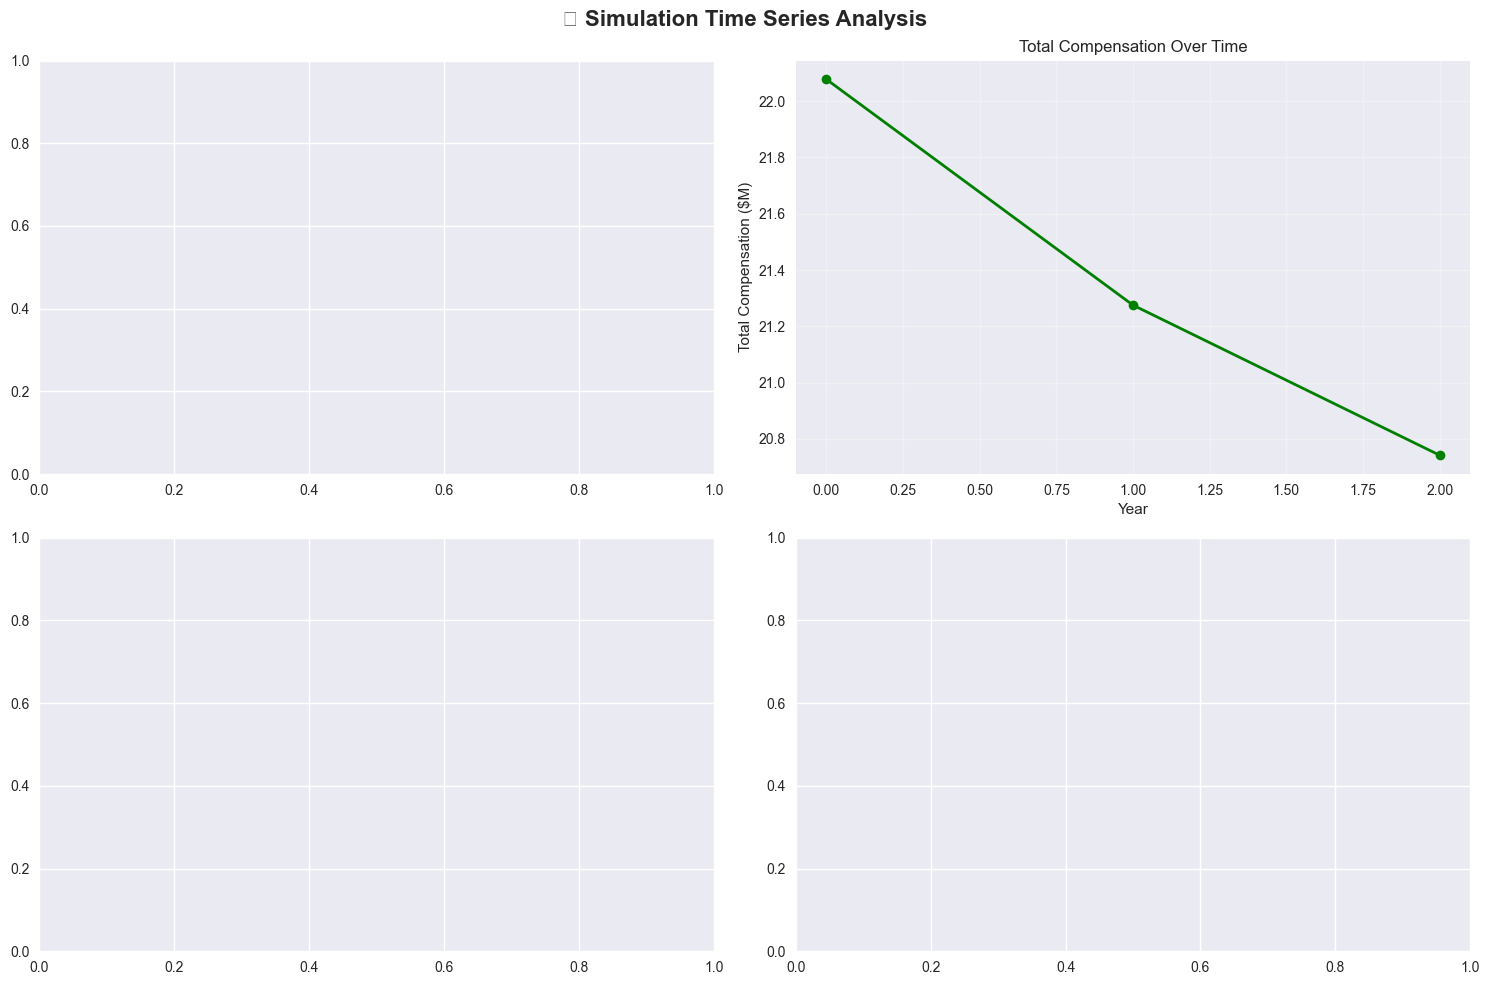

In [7]:
# 📈 Time Series Analysis
def plot_time_series(simulation_data):
    """Plot key metrics over time"""
    if not simulation_data or 'metrics' not in simulation_data:
        print("❌ No metrics data available")
        return
    
    metrics = simulation_data['metrics']
    
    if len(metrics) == 0:
        print("❌ No metrics data found")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('📈 Simulation Time Series Analysis', fontsize=16, fontweight='bold')
    
    # Headcount over time
    if 'total_employees' in metrics.columns:
        axes[0,0].plot(metrics.index, metrics['total_employees'], marker='o', linewidth=2, color='blue')
        axes[0,0].set_title('Total Headcount Over Time')
        axes[0,0].set_xlabel('Year')
        axes[0,0].set_ylabel('Total Employees')
        axes[0,0].grid(True, alpha=0.3)
    
    # Total compensation over time
    if 'total_compensation' in metrics.columns:
        axes[0,1].plot(metrics.index, metrics['total_compensation']/1e6, marker='o', linewidth=2, color='green')
        axes[0,1].set_title('Total Compensation Over Time')
        axes[0,1].set_xlabel('Year')
        axes[0,1].set_ylabel('Total Compensation ($M)')
        axes[0,1].grid(True, alpha=0.3)
    
    # Growth rates over time
    if 'hc_growth_rate' in metrics.columns:
        axes[1,0].plot(metrics.index, metrics['hc_growth_rate']*100, marker='o', linewidth=2, color='orange', label='HC Growth')
        axes[1,0].axhline(3, color='red', linestyle='--', alpha=0.7, label='Target (3%)')
        axes[1,0].set_title('Headcount Growth Rate')
        axes[1,0].set_xlabel('Year')
        axes[1,0].set_ylabel('Growth Rate (%)')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
    
    if 'comp_growth_rate' in metrics.columns:
        axes[1,1].plot(metrics.index, metrics['comp_growth_rate']*100, marker='o', linewidth=2, color='purple', label='Comp Growth')
        axes[1,1].axhline(3, color='red', linestyle='--', alpha=0.7, label='Target (3%)')
        axes[1,1].set_title('Compensation Growth Rate')
        axes[1,1].set_xlabel('Year')
        axes[1,1].set_ylabel('Growth Rate (%)')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot time series if data is available
if simulation_data:
    plot_time_series(simulation_data)

## 🔍 Event Analysis

Analyze hiring, termination, and promotion events from the simulation.

In [8]:
def analyze_events(simulation_data):
    """Analyze hiring, termination, and promotion events"""
    if not simulation_data or 'events' not in simulation_data:
        print("❌ No event data available")
        return
    
    events = simulation_data['events']
    
    # Aggregate events by type and year
    event_summary = {}
    
    for year, year_events in events.items():
        event_summary[year] = {}
        for event_type, event_df in year_events.items():
            event_summary[year][event_type] = len(event_df)
    
    # Convert to DataFrame for visualization
    summary_df = pd.DataFrame(event_summary).T.fillna(0)
    
    if len(summary_df) == 0:
        print("❌ No event data found")
        return
    
    # Plot event counts
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('🔍 Event Analysis', fontsize=14, fontweight='bold')
    
    # Event counts by year
    summary_df.plot(kind='bar', ax=axes[0], alpha=0.8)
    axes[0].set_title('Event Counts by Year')
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Number of Events')
    axes[0].legend(title='Event Type')
    axes[0].grid(True, alpha=0.3)
    
    # Event proportions
    event_totals = summary_df.sum()
    if len(event_totals) > 0:
        axes[1].pie(event_totals.values, labels=event_totals.index, autopct='%1.1f%%', startangle=90)
        axes[1].set_title('Event Distribution (Total)')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n📊 Event Summary:")
    for event_type, total in event_totals.items():
        print(f"   {event_type.title()}: {total} events")
    
    return summary_df

# Analyze events if data is available
if simulation_data:
    event_analysis = analyze_events(simulation_data)

❌ No event data found


## ⚙️ Parameter Sensitivity Analysis

Analyze how different parameter values affect simulation outcomes.

In [9]:
def parameter_sensitivity_analysis(campaign_results):
    """Analyze parameter sensitivity from campaign results"""
    if campaign_results is None:
        print("❌ No campaign results available for sensitivity analysis")
        return
    
    # Load configuration files to extract parameters
    config_params = []
    
    for idx, row in campaign_results.iterrows():
        config_path = Path(row['config_path'])
        if config_path.exists():
            try:
                with open(config_path, 'r') as f:
                    config = yaml.safe_load(f)
                
                # Extract key parameters
                params = {
                    'config_path': row['config_path'],
                    'score': row['score'],
                    'hc_growth': row['hc_growth'],
                    'pay_growth': row['pay_growth'],
                    'target_growth': config['global_parameters'].get('target_growth', None),
                    'new_hire_rate': config['global_parameters'].get('new_hires', {}).get('new_hire_rate', None),
                    'new_hire_avg_age': config['global_parameters'].get('new_hire_average_age', None),
                    'max_working_age': config['global_parameters'].get('max_working_age', None),
                    'base_term_rate': config['global_parameters'].get('termination_hazard', {}).get('base_rate_for_new_hire', None),
                    'term_mult_under_1': config['global_parameters'].get('termination_hazard', {}).get('tenure_multipliers', {}).get('<1', None),
                    'term_mult_under_30': config['global_parameters'].get('termination_hazard', {}).get('age_multipliers', {}).get('<30', None),
                }
                config_params.append(params)
            except Exception as e:
                print(f"⚠️ Could not load config {config_path}: {e}")
    
    if not config_params:
        print("❌ No configuration parameters could be loaded")
        return
    
    params_df = pd.DataFrame(config_params)
    
    # Correlation analysis
    numeric_cols = params_df.select_dtypes(include=[np.number]).columns
    correlation_matrix = params_df[numeric_cols].corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, 
                square=True, fmt='.2f', cbar_kws={'label': 'Correlation'})
    plt.title('⚙️ Parameter Correlation Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Key parameter vs outcome scatter plots
    key_params = ['target_growth', 'new_hire_rate', 'new_hire_avg_age', 'base_term_rate']
    key_params = [p for p in key_params if p in params_df.columns and params_df[p].notna().any()]
    
    if len(key_params) >= 2:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('⚙️ Parameter Sensitivity Analysis', fontsize=16, fontweight='bold')
        
        for i, param in enumerate(key_params[:4]):
            row, col = i // 2, i % 2
            
            # Score vs parameter
            scatter = axes[row, col].scatter(params_df[param], params_df['score'], 
                                           c=params_df['hc_growth']*100, cmap='viridis', alpha=0.7)
            axes[row, col].set_xlabel(param.replace('_', ' ').title())
            axes[row, col].set_ylabel('Score')
            axes[row, col].set_title(f'Score vs {param.replace("_", " ").title()}')
            axes[row, col].grid(True, alpha=0.3)
            
            # Add colorbar for HC growth
            cbar = plt.colorbar(scatter, ax=axes[row, col])
            cbar.set_label('HC Growth (%)')
        
        plt.tight_layout()
        plt.show()
    
    # Print top correlations with score
    if 'score' in correlation_matrix.columns:
        score_corr = correlation_matrix['score'].abs().sort_values(ascending=False)
        print("\n🎯 Parameters Most Correlated with Score:")
        for param, corr in score_corr.items():
            if param != 'score' and not pd.isna(corr):
                direction = "📈" if correlation_matrix.loc['score', param] > 0 else "📉"
                print(f"   {param}: {corr:.3f} {direction}")
    
    return params_df

# Run parameter sensitivity analysis
if campaign_results is not None:
    param_analysis = parameter_sensitivity_analysis(campaign_results)

❌ No configuration parameters could be loaded


## 🔄 Configuration Comparison

Compare multiple configurations side by side.

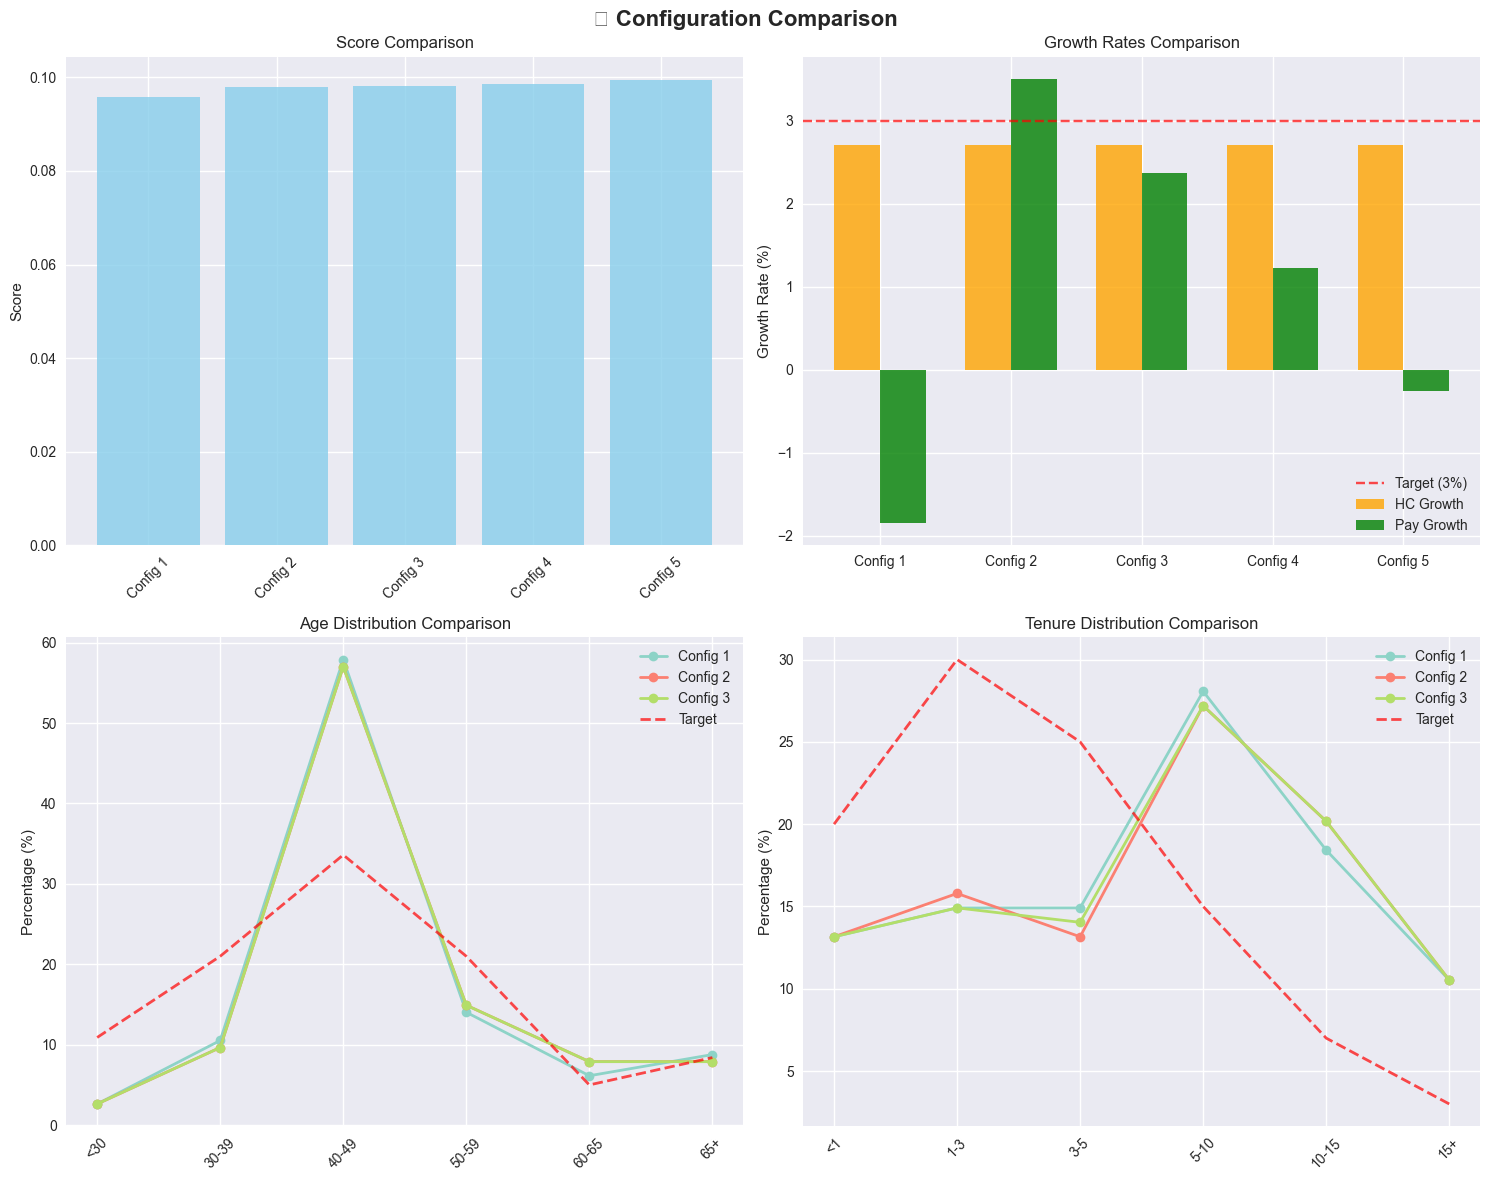


📊 Detailed Configuration Comparison:


,config_path,score,hc_growth,pay_growth,final_headcount
Config 1,tuned/config_038_20250608_174920.yaml,0.095837,2.7,-1.85,114
Config 2,tuned/config_016_20250608_174920.yaml,0.097886,2.7,3.51,114
Config 3,tuned/config_079_20250608_174920.yaml,0.098154,2.7,2.36,114
Config 4,tuned/config_145_20250608_174921.yaml,0.098519,2.7,1.23,114
Config 5,tuned/config_027_20250608_174920.yaml,0.099467,2.7,-0.26,114


In [10]:
def compare_configurations(campaign_results, config_names=None, top_n=5):
    """Compare multiple configurations side by side"""
    if campaign_results is None:
        print("❌ No campaign results available")
        return
    
    if config_names:
        # Compare specific configurations
        configs_to_compare = []
        for name in config_names:
            matches = campaign_results[campaign_results['config_path'].str.contains(name)]
            if not matches.empty:
                configs_to_compare.append(matches.iloc[0])
            else:
                print(f"⚠️ Configuration '{name}' not found")
        
        if not configs_to_compare:
            print("❌ No valid configurations found")
            return
        
        comparison_df = pd.DataFrame(configs_to_compare)
    else:
        # Compare top N configurations
        comparison_df = campaign_results.nsmallest(top_n, 'score')
    
    # Create comparison visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('🔄 Configuration Comparison', fontsize=16, fontweight='bold')
    
    # Score comparison
    config_labels = [f"Config {i+1}" for i in range(len(comparison_df))]
    axes[0,0].bar(config_labels, comparison_df['score'], alpha=0.8, color='skyblue')
    axes[0,0].set_title('Score Comparison')
    axes[0,0].set_ylabel('Score')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Growth rates comparison
    x = np.arange(len(comparison_df))
    width = 0.35
    
    axes[0,1].bar(x - width/2, comparison_df['hc_growth']*100, width, label='HC Growth', alpha=0.8, color='orange')
    axes[0,1].bar(x + width/2, comparison_df['pay_growth']*100, width, label='Pay Growth', alpha=0.8, color='green')
    axes[0,1].axhline(3, color='red', linestyle='--', alpha=0.7, label='Target (3%)')
    axes[0,1].set_title('Growth Rates Comparison')
    axes[0,1].set_ylabel('Growth Rate (%)')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels(config_labels)
    axes[0,1].legend()
    
    # Age distribution comparison (for first few configs)
    age_bands = ['<30', '30-39', '40-49', '50-59', '60-65', '65+']
    colors = plt.cm.Set3(np.linspace(0, 1, len(comparison_df)))
    
    for i, (idx, config) in enumerate(comparison_df.head(3).iterrows()):
        # Reconstruct age_hist from flattened columns
        age_hist = {col.replace('age_hist.', ''): config[col] for col in config.index if col.startswith('age_hist.')}
        age_values = [age_hist.get(band, 0)*100 for band in age_bands]
        axes[1,0].plot(age_bands, age_values, marker='o', label=f'Config {i+1}', color=colors[i], linewidth=2)
    
    # Add target line
    target_age = [10.9, 21.0, 33.6, 21.0, 5.0, 8.4]
    axes[1,0].plot(age_bands, target_age, 'r--', label='Target', linewidth=2, alpha=0.7)
    axes[1,0].set_title('Age Distribution Comparison')
    axes[1,0].set_ylabel('Percentage (%)')
    axes[1,0].legend()
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Tenure distribution comparison (for first few configs)
    tenure_bands = ['<1', '1-3', '3-5', '5-10', '10-15', '15+']
    
    for i, (idx, config) in enumerate(comparison_df.head(3).iterrows()):
        # Reconstruct tenure_hist from flattened columns
        tenure_hist = {col.replace('tenure_hist.', ''): config[col] for col in config.index if col.startswith('tenure_hist.')}
        tenure_values = [tenure_hist.get(band, 0)*100 for band in tenure_bands]
        axes[1,1].plot(tenure_bands, tenure_values, marker='o', label=f'Config {i+1}', color=colors[i], linewidth=2)
    
    # Add target line
    target_tenure = [20, 30, 25, 15, 7, 3]
    axes[1,1].plot(tenure_bands, target_tenure, 'r--', label='Target', linewidth=2, alpha=0.7)
    axes[1,1].set_title('Tenure Distribution Comparison')
    axes[1,1].set_ylabel('Percentage (%)')
    axes[1,1].legend()
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison table
    print("\n📊 Detailed Configuration Comparison:")
    comparison_summary = comparison_df[['config_path', 'score', 'hc_growth', 'pay_growth', 'final_headcount']].copy()
    comparison_summary['hc_growth'] = (comparison_summary['hc_growth'] * 100).round(2)
    comparison_summary['pay_growth'] = (comparison_summary['pay_growth'] * 100).round(2)
    comparison_summary['score'] = comparison_summary['score'].round(6)
    comparison_summary.index = [f"Config {i+1}" for i in range(len(comparison_summary))]
    display(comparison_summary)
    
    return comparison_df

# Compare top 5 configurations
if campaign_results is not None:
    config_comparison = compare_configurations(campaign_results, top_n=5)

## 🛠️ Utility Functions

Helper functions for custom analysis.

In [11]:
def export_analysis_report(campaign_results, output_file='analysis_report.html'):
    """Export a comprehensive analysis report"""
    if campaign_results is None:
        print("❌ No campaign results to export")
        return
    
    # Create HTML report
    html_content = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>Cost Model Analysis Report</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 40px; }}
            .header {{ background-color: #f0f0f0; padding: 20px; border-radius: 5px; }}
            .metric {{ margin: 10px 0; }}
            .best-config {{ background-color: #e8f5e8; padding: 15px; border-radius: 5px; margin: 20px 0; }}
            table {{ border-collapse: collapse; width: 100%; margin: 20px 0; }}
            th, td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
            th {{ background-color: #f2f2f2; }}
        </style>
    </head>
    <body>
        <div class=\"header\">
            <h1>📊 Cost Model Analysis Report</h1>
            <p>Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
        </div>
        
        <h2>📈 Campaign Summary</h2>
        <div class=\"metric\">Total Configurations: {len(campaign_results)}</div>
        <div class=\"metric\">Best Score: {campaign_results['score'].min():.6f}</div>
        <div class=\"metric\">Mean Score: {campaign_results['score'].mean():.6f}</div>
        <div class=\"metric\">Score Range: {campaign_results['score'].min():.6f} - {campaign_results['score'].max():.6f}</div>
        
        <div class=\"best-config\">
            <h3>🏆 Best Configuration</h3>
            <p><strong>Config:</strong> {campaign_results.loc[campaign_results['score'].idxmin(), 'config_path']}</p>
            <p><strong>Score:</strong> {campaign_results['score'].min():.6f}</p>
            <p><strong>HC Growth:</strong> {campaign_results.loc[campaign_results['score'].idxmin(), 'hc_growth']*100:.2f}%</p>
            <p><strong>Pay Growth:</strong> {campaign_results.loc[campaign_results['score'].idxmin(), 'pay_growth']*100:.2f}%</p>
        </div>
    """
    
    # Add top 10 table header
    html_content += """
        <h2>📊 Top 10 Configurations</h2>
        <table>
            <tr>
                <th>Rank</th>
                <th>Configuration</th>
                <th>Score</th>
                <th>HC Growth (%)</th>
                <th>Pay Growth (%)</th>
                <th>Final Headcount</th>
            </tr>
    """
    
    # Add top 10 configurations to table
    top_10 = campaign_results.nsmallest(10, 'score')
    for i, (idx, row) in enumerate(top_10.iterrows()):
        html_content += f"""
            <tr>
                <td>{i+1}</td>
                <td>{row['config_path']}</td>
                <td>{row['score']:.6f}</td>
                <td>{row['hc_growth']*100:.2f}</td>
                <td>{row['pay_growth']*100:.2f}</td>
                <td>{row['final_headcount']}</td>
            </tr>
        """
    
    html_content += """
        </table>
    </body>
    </html>
    """
    
    # Write to file
    with open(output_file, 'w') as f:
        f.write(html_content)
    
    print(f"✅ Analysis report exported to: {output_file}")

def calculate_score_components(age_hist, tenure_hist, hc_growth, pay_growth):
    """Calculate individual score components for custom analysis"""
    # Target distributions
    target_age = {'<30': 0.109, '30-39': 0.210, '40-49': 0.336, '50-59': 0.210, '60-65': 0.050, '65+': 0.084}
    target_tenure = {'<1': 0.20, '1-3': 0.30, '3-5': 0.25, '5-10': 0.15, '10-15': 0.07, '15+': 0.03}
    
    # Calculate KL divergence for age
    age_error = 0
    for band in target_age:
        p_val = target_age[band]
        q_val = age_hist.get(band, 0.001)  # Small value to avoid log(0)
        if q_val > 0:
            age_error += p_val * np.log(p_val / q_val)
    
    # Calculate KL divergence for tenure
    tenure_error = 0
    for band in target_tenure:
        p_val = target_tenure[band]
        q_val = tenure_hist.get(band, 0.001)
        if q_val > 0:
            tenure_error += p_val * np.log(p_val / q_val)
    
    # Growth errors
    hc_growth_error = abs(hc_growth - 0.03)  # 3% target
    pay_growth_error = abs(pay_growth - 0.03)  # 3% target
    
    # Weights (Campaign 2 weights)
    WEIGHT_AGE = 0.30
    WEIGHT_TENURE = 0.30
    WEIGHT_HC_GROWTH = 0.30
    WEIGHT_PAY_GROWTH = 0.10
    
    # Calculate total score
    total_score = (WEIGHT_AGE * age_error + 
                   WEIGHT_TENURE * tenure_error + 
                   WEIGHT_HC_GROWTH * hc_growth_error + 
                   WEIGHT_PAY_GROWTH * pay_growth_error)
    
    return {
        'age_error': age_error,
        'tenure_error': tenure_error,
        'hc_growth_error': hc_growth_error,
        'pay_growth_error': pay_growth_error,
        'total_score': total_score
    }

print("🛠️ Utility functions loaded successfully!")
print("\n📋 Available Functions:")
print("   • export_analysis_report() - Export HTML report")
print("   • calculate_score_components() - Calculate score breakdown")
print("   • analyze_demographics() - Analyze age/tenure distributions")
print("   • compare_configurations() - Compare multiple configs")
print("   • parameter_sensitivity_analysis() - Analyze parameter effects")

🛠️ Utility functions loaded successfully!

📋 Available Functions:
   • export_analysis_report() - Export HTML report
   • calculate_score_components() - Calculate score breakdown
   • analyze_demographics() - Analyze age/tenure distributions
   • compare_configurations() - Compare multiple configs
   • parameter_sensitivity_analysis() - Analyze parameter effects


## 🎯 Custom Analysis Section

Use this section for your own custom analysis and exploration.

In [12]:
# 🎯 Your custom analysis goes here!
# Examples:

# 1. Analyze a specific configuration
# analyze_demographics(campaign_results, config_name='config_097')

# 2. Compare specific configurations
# compare_configurations(campaign_results, config_names=['config_097', 'config_008', 'config_042'])

# 3. Export analysis report
# export_analysis_report(campaign_results, 'my_analysis_report.html')

# 4. Calculate custom score components
# if campaign_results is not None:
#     best_config = campaign_results.loc[campaign_results['score'].idxmin()]
#     # Reconstruct age_hist and tenure_hist from flattened columns
#     age_hist = {col.replace('age_hist.', ''): best_config[col] for col in best_config.index if col.startswith('age_hist.')}
#     tenure_hist = {col.replace('tenure_hist.', ''): best_config[col] for col in best_config.index if col.startswith('tenure_hist.')}
#     score_breakdown = calculate_score_components(
#         age_hist, tenure_hist,
#         best_config['hc_growth'], 
#         best_config['pay_growth']
#     )
#     print("Score Breakdown:", score_breakdown)

print("✨ Ready for your custom analysis!")
print("💡 Uncomment and modify the examples above to get started.")

✨ Ready for your custom analysis!
💡 Uncomment and modify the examples above to get started.
